# <center>Predicting Football Match Outcome
### <center> **Prathamesh Tari**  
<center> INFO 7390, Fall 2017, Northeastern University, tari.p@husky.neu.edu

   European Football or soccer is the world’s most popular team sport. It is played by over 150 million men and women of all ages in more than 200 countries [1].It is also one of the favorite sports for betting. The current estimations, which include both the illegal markets and the legal markets, suggest the sports match-betting industry is worth anywhere between 700bn and 1tn dollars a year [2]. 
   
The bookies have their own prediction model and they get it right about 53% of the time [3].
Football pundit Mark Lawrenson had prediction accuracy of 52.6% [4]. 
The aim of this project is to build a system to predict the outcome using machine learning algorithms like Support Vector Machine, Naïve Bayes and logistic Regression.

### Dataset

I am using two datasets for this project. The first dataset I got the data science community Kaggle https://www.kaggle.com/hugomathien/soccer. This dataset is used to perform exploratory data analysis. But this dataset has few missing data essential for prediction so the second dataset I am using is from http://football-data.co.uk/data.php. This dataset had more seasons and I am compiling these seasons into one and creating features to make prediction

Initially I am performing Exploratory Data Analysis on the dataset I got from the Kaggle website.

This dataset was in sqlite format and has tables of Country, League, Match, Player, Player Attributes, Team ,Team Attributes and sequences. It has information of more than 25000 matches, 10000 players, 11 European Countries with their lead championship from 2008 to 2016, Players and Teams attributes sourced from EA Sports' FIFA video game series, betting odds from up to 10 providers


I am only going to use the information from country, match, league and team for the EDA. This are the information which would be useful to understand the game.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.gridspec as gridspec
from numpy import random
import scipy.stats as scipy

from IPython.display import display

from sklearn.metrics import accuracy_score

with sqlite3.connect('./dataset/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    tempmatch = pd.read_sql_query("SELECT * from Match", con)
    matches3 = matches2 = matches

In [2]:
matches.tail()
#matches.describe()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
25974,25975,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992091,10190,10191,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25975,25976,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992092,9824,10199,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25976,25977,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992093,9956,10179,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25977,25978,24558,24558,2015/2016,9,2015-09-22 00:00:00,1992094,7896,10243,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25978,25979,24558,24558,2015/2016,9,2015-09-23 00:00:00,1992095,10192,9931,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
countries

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [4]:
leagues

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [5]:
teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB
...,...,...,...,...,...
294,49479,10190,898.0,FC St. Gallen,GAL
295,49837,10191,1715.0,FC Thun,THU
296,50201,9777,324.0,Servette FC,SER
297,50204,7730,1862.0,FC Lausanne-Sports,LAU


In [6]:
def res(row):
    if row['home_team_goal'] == row['away_team_goal']:
        val = 0
    elif row['home_team_goal'] > row['away_team_goal']:
        val = 1
    else:
        val = -1
    return val

   #                      Probability of winning from Betting odds
!["Betting Odds"](files/odds.png "Betting odds probability")

#### Calculating entropy to determine predictability

Entropy is calculated to measure the disorder using bet365 odds. The higher the entropy value the more unpredictable are the resuts of the matches.

In [7]:
from scipy.stats import entropy

def match_entropy(row):
    odds = [row['B365H'],row['B365D'],row['B365A']]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)

In [8]:
# Considering English Premier League

main_countries = ['England']
countries = countries[countries.name.isin(main_countries)]
leagues = countries.merge(leagues,on='id',suffixes=('', '_y'))
seasons = matches.season.unique()
leagues

,id,name,country_id,name_y
0,1729,England,1729,England Premier League


In [9]:
#Merge the leagues with corresponding matches

req_matches = matches2[matches2.league_id.isin(leagues['id'])]
req_matches.tail()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
4763,4764,1729,1729,2015/2016,9,2015-10-17 00:00:00,1988795,8466,8197,2,...,NaN,1.75,3.9,5.0,NaN,NaN,NaN,NaN,NaN,NaN
4764,4765,1729,1729,2015/2016,9,2015-10-19 00:00:00,1988796,10003,10194,0,...,NaN,2.05,3.4,4.1,NaN,NaN,NaN,NaN,NaN,NaN
4765,4766,1729,1729,2015/2016,9,2015-10-17 00:00:00,1988797,8586,8650,0,...,NaN,2.45,3.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4766,4767,1729,1729,2015/2016,9,2015-10-17 00:00:00,1988798,9817,9825,0,...,NaN,6.25,4.2,1.6,NaN,NaN,NaN,NaN,NaN,NaN
4767,4768,1729,1729,2015/2016,9,2015-10-17 00:00:00,1988799,8659,8472,1,...,NaN,2.05,3.3,4.2,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
req_matches = req_matches[['id','country_id','league_id', 'date', 'match_api_id','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal','season']]
req_matches["total_goals"] = req_matches['home_team_goal'] + req_matches['away_team_goal']
req_matches["result"] = req_matches.apply(res,axis = 1)
req_matches.dropna(inplace=True)

In [11]:
req_matches.tail()

,id,country_id,league_id,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,season,total_goals,result
4763,4764,1729,1729,2015-10-17 00:00:00,1988795,8466,8197,2,2,2015/2016,4,0
4764,4765,1729,1729,2015-10-19 00:00:00,1988796,10003,10194,0,1,2015/2016,1,-1
4765,4766,1729,1729,2015-10-17 00:00:00,1988797,8586,8650,0,0,2015/2016,0,0
4766,4767,1729,1729,2015-10-17 00:00:00,1988798,9817,9825,0,3,2015/2016,3,-1
4767,4768,1729,1729,2015-10-17 00:00:00,1988799,8659,8472,1,0,2015/2016,1,1


In [12]:
new_matches = pd.merge(req_matches,leagues,left_on='league_id', right_on='id')
new_matches = new_matches.drop(['id_y','country_id_y'], axis = 1)
new_matches = new_matches.rename(columns = {'id_x': 'id', 'country_id_x': 'country_id'})
english = new_matches[new_matches.name == "England"]

# sum_goals = new_group_matches.home_team_goal.sum()
e = english.groupby('season')
seasons
%matplotlib inline

Home advantages always played important part in match outcome. But by what factor does home advantage affects the match.

### Getting total number of goals scored in Home matches

In [13]:
num_seasons = range(len(seasons))

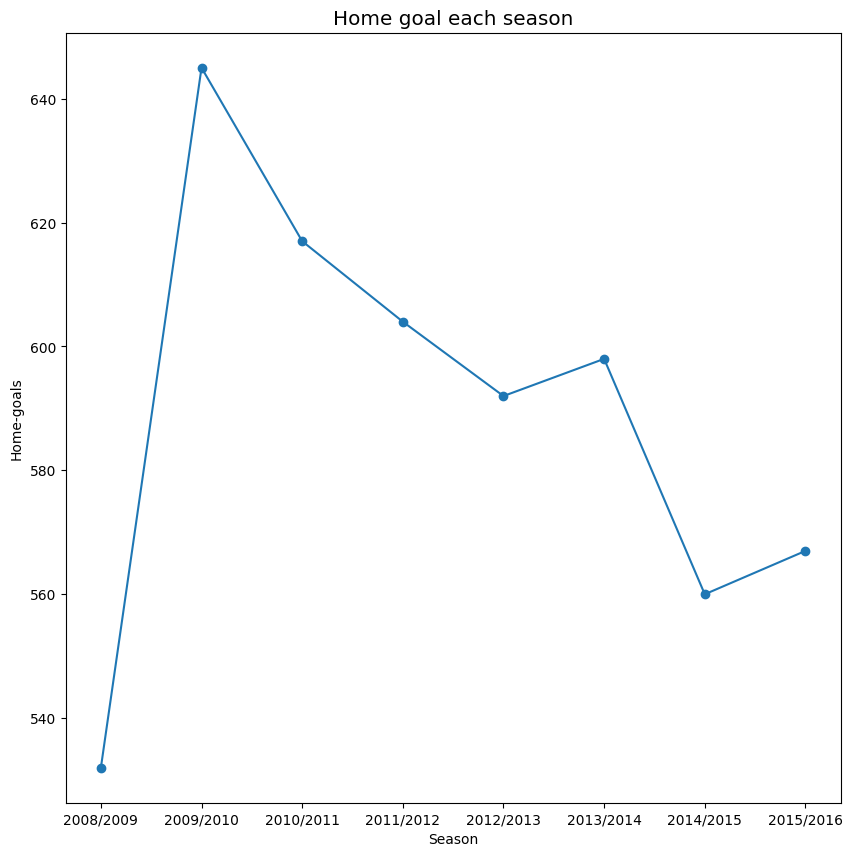

In [14]:
#Plotting home scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Home goal each season')
plt.xlabel('Season')
plt.ylabel('Home-goals')
plt.plot(num_seasons,e.home_team_goal.sum().values,label = "English Premier League", marker = 'o')


### Total number of goals scored in Away matches

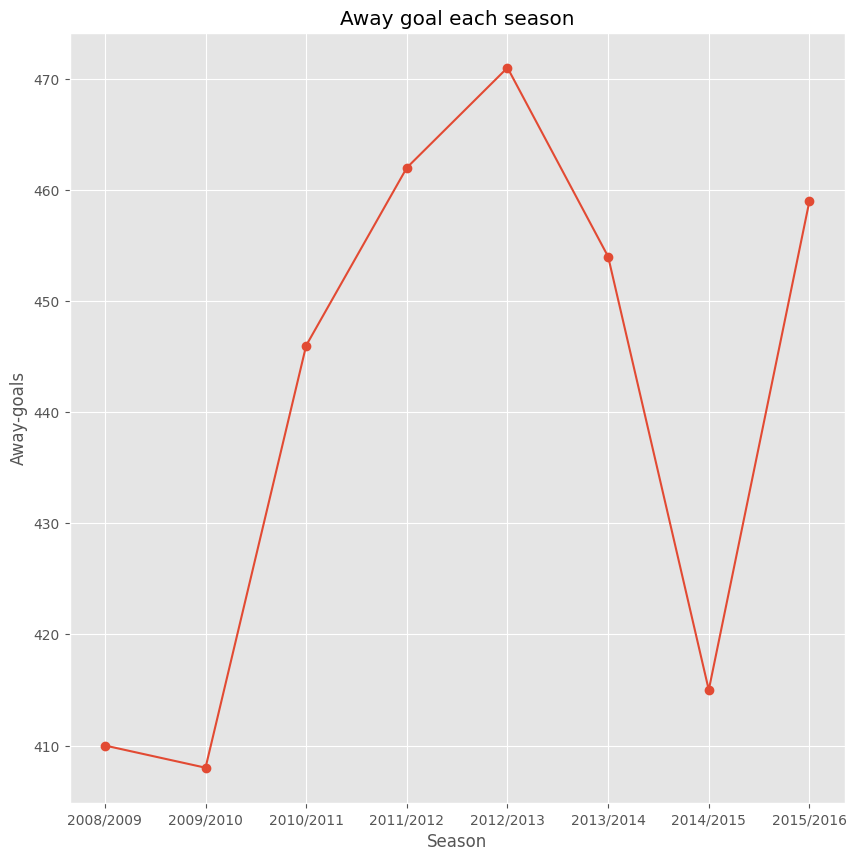

In [15]:
#Plotting away scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Away goal each season')
plt.xlabel('Season')
plt.ylabel('Away-goals')
plt.plot(num_seasons,e.away_team_goal.sum().values,label = "English Premier League", marker = 'o')


### Home goals to Away goals ratio

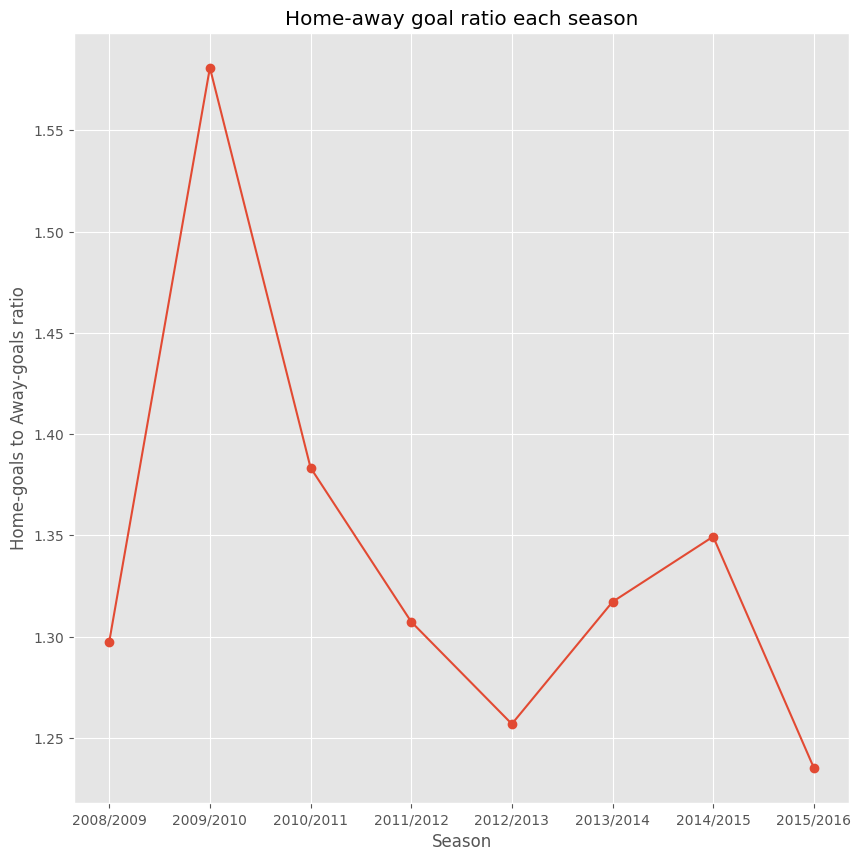

In [16]:
#Plotting home/away scored each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.title('Home-away goal ratio each season')
plt.xlabel('Season')
plt.ylabel('Home-goals to Away-goals ratio')
plt.plot(num_seasons,e.home_team_goal.sum().values / e.away_team_goal.sum().values,label = "English Premier League", marker = 'o')


### Home wins vs Home Loss

array([1.57272727, 2.12087912, 1.98888889, 1.47413793, 1.56603774,
       1.45528455, 1.49565217, 1.35344828])

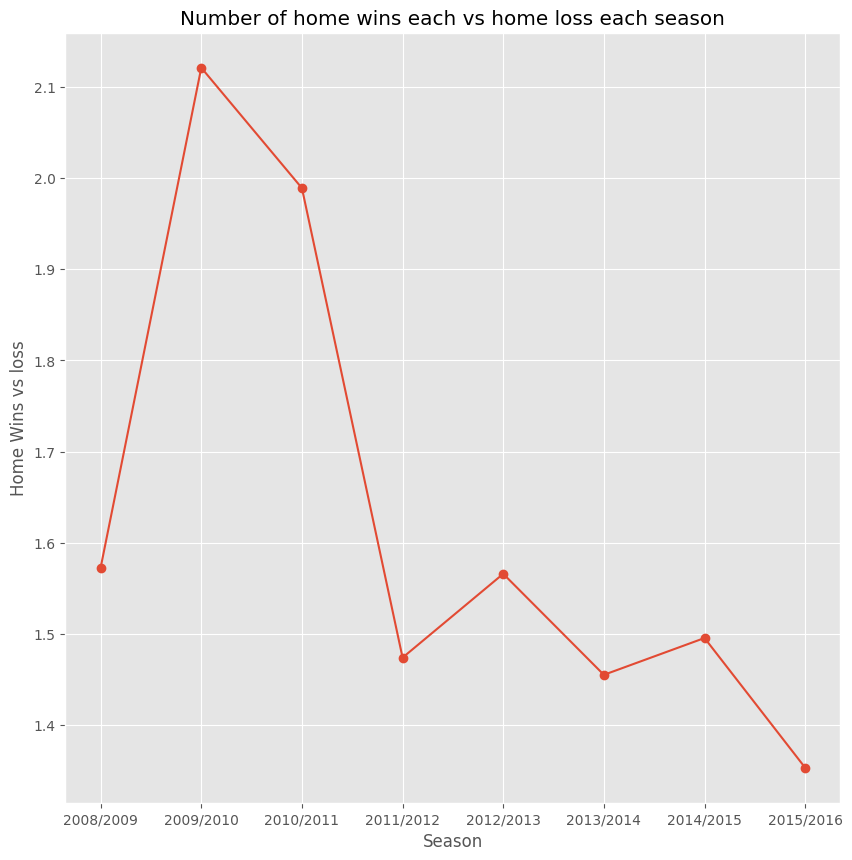

In [17]:
#Subsetting homewins vs homeloss from each of the leagues - ignoring draws.
e_hw = np.true_divide(english[english.result == 1].groupby('season').result.sum().values,english[english.result == -1].groupby('season').result.sum().values * -1)


#Plotting number of home wins vs home losses each season
fig = plt.figure(figsize=(10, 10))
plt.xticks(range(len(seasons)),seasons)
plt.style.use('ggplot')
plt.xlim = (-20,20)
plt.ylim = (0,120)
plt.title("Number of home wins each vs home loss each season")
plt.xlabel("Season")
plt.ylabel("Home Wins vs loss")
plt.plot(num_seasons,e_hw,label = "English Premier League", marker = 'o')
display(e_hw)

We can clearly see that the home advantage in premier league is decreasing every season. Initially home matches were very good factor to determine the winner of the match. Now the matches have become very competitive and we cannot predict the match outcome just on the home advantage.

## Prediction 

We downloaded the data of English Premier League from 2000 from http://football-data.co.uk/data.php

This dataset contains information of all the game statistics like fulltime goals, halftime goals, corners, free kicks, fouls, yellow cards, red cards, total shots, shots on target etc.

In [18]:
# Read data from the CSV into a dataframe

loc = "./dataset/"

raw_data_1 = pd.read_csv("./dataset/2000-01.csv")
raw_data_2 = pd.read_csv("./dataset/2001-02.csv")
raw_data_3 = pd.read_csv("./dataset/2002-03.csv")
raw_data_4 = pd.read_csv("./dataset/2003-04.csv")
raw_data_5 = pd.read_csv("./dataset/2004-05.csv")
raw_data_6 = pd.read_csv("./dataset/2005-06.csv")
raw_data_7 = pd.read_csv("./dataset/2006-07.csv")
raw_data_8 = pd.read_csv("./dataset/2007-08.csv")
raw_data_9 = pd.read_csv("./dataset/2008-09.csv")
raw_data_10 = pd.read_csv("./dataset/2009-10.csv")
raw_data_11 = pd.read_csv("./dataset/2010-11.csv")
raw_data_12 = pd.read_csv("./dataset/2011-12.csv")
raw_data_13 = pd.read_csv("./dataset/2012-13.csv")
raw_data_14 = pd.read_csv("./dataset/2013-14.csv")
raw_data_15 = pd.read_csv("./dataset/2014-15.csv")
raw_data_16 = pd.read_csv("./dataset/2015-16.csv")

Selecting the required features and putting it in the dataframe

In [20]:
# Selecting the features

raw_data_1 =raw_data_1[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_2 =raw_data_2[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_3 =raw_data_3[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_4 =raw_data_4[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_5 =raw_data_5[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_6 =raw_data_6[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_7 =raw_data_7[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_8 =raw_data_8[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_9 =raw_data_9[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_10 =raw_data_10[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_11 =raw_data_11[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_12 =raw_data_12[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_13 =raw_data_13[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_14 =raw_data_14[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_15 =raw_data_15[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]
raw_data_16 =raw_data_16[['Div', 'Date', 'HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']]


In [21]:
# Concating the data on one dataframe

playing_stat = pd.concat([raw_data_1,raw_data_2,raw_data_3,raw_data_4,raw_data_5,raw_data_6,raw_data_7,raw_data_8,raw_data_9,raw_data_10,raw_data_11,raw_data_12,raw_data_13,raw_data_14,raw_data_15,raw_data_16],ignore_index=True, axis=0)

In [22]:
playing_stat.tail()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
6075,E0,15/05/16,Stoke,West Ham,2,1,H,0,1,A,...,4,7,8,12,4,10,3,1,0,0
6076,E0,15/05/16,Swansea,Man City,1,1,D,1,1,D,...,1,5,4,19,4,4,1,3,0,0
6077,E0,15/05/16,Watford,Sunderland,2,2,D,0,1,A,...,6,4,11,10,7,4,1,0,0,0
6078,E0,15/05/16,West Brom,Liverpool,1,1,D,1,1,D,...,1,3,11,14,7,5,3,1,0,0
6079,E0,17/05/16,Man United,Bournemouth,3,1,H,1,0,H,...,5,0,9,8,7,1,1,0,0,0


    FTHG - Full Time Home Goal
    FTAG - Half Time Away Goal
    FTR - Full Time Result
    HTHG - Half Time Home Goal
    HTAG - Half Time Away Goal
    HTR - Half Time Result
    HS - Home Shots
    AS - Away Shots
    HST - Home Shots on Target
    AST - Away Shots on Target
    HF - Home Team Foul
    AF - Away Team Foul
    HC - Home Team Corner
    AC - Away Team Corner
    HY - Home Team Yellow Card
    Ay - Away Team Yellow Card
    HR - Home Team Red Card
    Ar - Away Team Red Card

In [23]:
# Creating csv file from the merged dataframe

playing_stat.to_csv(loc + "Merged_dataset.csv")


Created a csv file from the data for future analysis

In [2]:
df = pd.read_csv("./dataset/Merged_dataset.csv")


In [3]:
table = pd.DataFrame(columns=('Team','HGS','AGS','HAS','AAS','HGC','AGC','HDS','ADS'))

avg_home_scored = df.FTHG.sum() / 6080.0
avg_away_scored = df.FTAG.sum() / 6080.0
avg_home_conceded = avg_away_scored
avg_away_conceded = avg_home_scored
print(avg_away_conceded)


1.522861842105263


In [4]:
res_home = df.groupby('HomeTeam')
res_away = df.groupby('AwayTeam')

We calculate attacking strength of each team at home and away from goals scored at home and away. We will use this as a feature in our prediction model.

In [5]:
table.Team = sorted(df.HomeTeam.unique())
table.HGS = res_home.FTHG.sum().values
table.HGC = res_home.FTAG.sum().values
table.AGS = res_away.FTAG.sum().values
table.AGC = res_away.FTHG.sum().values
#19 Home matches for each team each season and 16 seasons therefore 304 home matches and 304 away matches
table.HAS = (table.HGS / 304.0) / avg_home_scored
table.AAS = (table.AGS / 304.0) / avg_away_scored
table.HDS = (table.HGC / 304.0) / avg_home_conceded
table.ADS = (table.AGC / 304.0) / avg_away_conceded

table

,Team,HGS,AGS,HAS,AAS,HGC,AGC,HDS,ADS
0,Arsenal,662,503,1.429960,1.471190,253,342,0.739982,0.738741
1,Aston Villa,377,341,0.814343,0.997368,341,501,0.997368,1.082190
2,Birmingham,162,111,0.349930,0.324656,140,220,0.409476,0.475213
3,Blackburn,289,229,0.624257,0.669786,239,353,0.699035,0.762501
4,Blackpool,30,25,0.064802,0.073121,37,41,0.108219,0.088562
5,Bolton,278,217,0.600497,0.634689,260,353,0.760456,0.762501
6,Bournemouth,23,22,0.049681,0.064346,34,33,0.099444,0.071282
7,Bradford,20,10,0.043201,0.029248,29,41,0.084820,0.088562
8,Burnley,39,31,0.084242,0.090670,51,84,0.149166,0.181445
9,Cardiff,20,12,0.043201,0.035098,35,39,0.102369,0.084242


HGS - Home Goals Scored

HGC - Home Goals Conceded

AGS - Away Goals Scored

AGS - Away Goals Conceded

HAS - Home Attacking Strength

HDS - Home Defensive Strength

AAS - Away Attacking Strength

ADS - Away Defensive Strength

In [6]:
df.tail()

,Unnamed: 0,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
6075,6075,E0,15/05/16,Stoke,West Ham,2,1,H,0,1,...,4,7,8,12,4,10,3,1,0,0
6076,6076,E0,15/05/16,Swansea,Man City,1,1,D,1,1,...,1,5,4,19,4,4,1,3,0,0
6077,6077,E0,15/05/16,Watford,Sunderland,2,2,D,0,1,...,6,4,11,10,7,4,1,0,0,0
6078,6078,E0,15/05/16,West Brom,Liverpool,1,1,D,1,1,...,1,3,11,14,7,5,3,1,0,0
6079,6079,E0,17/05/16,Man United,Bournemouth,3,1,H,1,0,...,5,0,9,8,7,1,1,0,0,0


In [7]:
import pandas as pd

# Assuming df and table are already defined DataFrames

# Step 1: Extract necessary features from df
feature_table = df.iloc[:, :23][['HomeTeam', 'AwayTeam', 'FTR', 'HST', 'AST', 'HC', 'AC']]

# Step 2: Initialize lists to store the additional features
f_HAS = []
f_HDS = []
f_AAS = []
f_ADS = []

# Step 3: Loop through each row in feature_table to get the corresponding HAS, HDS, AAS, ADS values
for index, row in feature_table.iterrows():
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    
    # Retrieve values from table based on team names
    has = table.loc[table['Team'] == home_team, 'HAS'].values
    hds = table.loc[table['Team'] == home_team, 'HDS'].values
    aas = table.loc[table['Team'] == away_team, 'AAS'].values
    ads = table.loc[table['Team'] == away_team, 'ADS'].values
    
    # Check if the team values exist and append to the lists
    f_HAS.append(has[0] if len(has) > 0 else None)
    f_HDS.append(hds[0] if len(hds) > 0 else None)
    f_AAS.append(aas[0] if len(aas) > 0 else None)
    f_ADS.append(ads[0] if len(ads) > 0 else None)

# Step 4: Add the new features to feature_table
feature_table['HAS'] = f_HAS
feature_table['HDS'] = f_HDS
feature_table['AAS'] = f_AAS
feature_table['ADS'] = f_ADS

# Display the final feature_table
feature_table.head()


,HomeTeam,AwayTeam,FTR,HST,AST,HC,AC,HAS,HDS,AAS,ADS
0,Charlton,Man City,H,14,4,6,6,0.386651,0.520620,1.114361,0.838103
1,Chelsea,West Ham,H,10,5,7,7,1.404039,0.693185,0.701960,0.876985
2,Coventry,Middlesbrough,A,3,9,8,4,0.030241,0.067271,0.412401,0.470893
3,Derby,Southampton,D,4,6,5,8,0.118803,0.272009,0.500146,0.540015
4,Leeds,Everton,H,8,6,6,4,0.252727,0.289558,0.956420,0.896425


In [8]:
df.tail()

,Unnamed: 0,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
6075,6075,E0,15/05/16,Stoke,West Ham,2,1,H,0,1,...,4,7,8,12,4,10,3,1,0,0
6076,6076,E0,15/05/16,Swansea,Man City,1,1,D,1,1,...,1,5,4,19,4,4,1,3,0,0
6077,6077,E0,15/05/16,Watford,Sunderland,2,2,D,0,1,...,6,4,11,10,7,4,1,0,0,0
6078,6078,E0,15/05/16,West Brom,Liverpool,1,1,D,1,1,...,1,3,11,14,7,5,3,1,0,0
6079,6079,E0,17/05/16,Man United,Bournemouth,3,1,H,1,0,...,5,0,9,8,7,1,1,0,0,0


In [10]:
df = df[['Div', 'Date', 'HR', 'AR', 'FTHG', 'HTAG']]
df.tail()

,Div,Date,HR,AR,FTHG,HTAG
6075,E0,15/05/16,0,0,2,1
6076,E0,15/05/16,0,0,1,1
6077,E0,15/05/16,0,0,2,1
6078,E0,15/05/16,0,0,1,1
6079,E0,17/05/16,0,0,3,0


In [11]:
df = pd.concat([df, feature_table], axis = 1)
df.tail()

,Div,Date,HR,AR,FTHG,HTAG,HomeTeam,AwayTeam,FTR,HST,AST,HC,AC,HAS,HDS,AAS,ADS
6075,E0,15/05/16,0,0,2,1,Stoke,West Ham,H,4,7,4,10,0.440652,0.465048,0.701960,0.876985
6076,E0,15/05/16,0,0,1,1,Swansea,Man City,D,1,5,4,4,0.291608,0.327581,1.114361,0.838103
6077,E0,15/05/16,0,0,2,1,Watford,Sunderland,D,6,4,7,4,0.084242,0.128693,0.640538,0.915866
6078,E0,15/05/16,0,0,1,1,West Brom,Liverpool,D,1,3,7,5,0.501134,0.792629,1.307400,0.797062
6079,E0,17/05/16,0,0,3,0,Man United,Bournemouth,H,5,0,7,1,1.440760,0.628839,0.064346,0.071282


Converting the features to csv file

In [33]:
df.to_csv(loc + "Feature_table.csv")


In [12]:
#Function to transform FTR into numeric data type
def transformResult(row):
    if(row.FTR == 'H'):
        return 1
    elif(row.FTR == 'A'):
        return -1
    else:
        return 0

In [13]:
df["Result"] = df.apply(lambda row: transformResult(row),axis=1)
df.tail()

,Div,Date,HR,AR,FTHG,HTAG,HomeTeam,AwayTeam,FTR,HST,AST,HC,AC,HAS,HDS,AAS,ADS,Result
6075,E0,15/05/16,0,0,2,1,Stoke,West Ham,H,4,7,4,10,0.440652,0.465048,0.701960,0.876985,1
6076,E0,15/05/16,0,0,1,1,Swansea,Man City,D,1,5,4,4,0.291608,0.327581,1.114361,0.838103,0
6077,E0,15/05/16,0,0,2,1,Watford,Sunderland,D,6,4,7,4,0.084242,0.128693,0.640538,0.915866,0
6078,E0,15/05/16,0,0,1,1,West Brom,Liverpool,D,1,3,7,5,0.501134,0.792629,1.307400,0.797062,0
6079,E0,17/05/16,0,0,3,0,Man United,Bournemouth,H,5,0,7,1,1.440760,0.628839,0.064346,0.071282,1


In [36]:
df['Result'].to_csv(loc + "Result.csv")

In [14]:
df.to_csv("./dataset/total_dataset_v02.csv")